<a href="https://colab.research.google.com/github/ankitpatnala/siemens_hackathon/blob/master/software/train_help/ehighway.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [84]:
!pip install open3d-python

In [85]:
# !python /content/drive/MyDrive/siemenschallenge5_2021/software/train_help/train.py

In [86]:
!python /content/drive/My\ Drive/siemenschallenge5_2021/software/example_2_project_to_camera.py

Reading PLY: [========================================] 100%
/content/drive/My Drive/siemenschallenge5_2021/software/highway_data/planar2/sideview_000000_000003.jpg
img type (2056, 2464, 3)


In [87]:
!python /content/drive/My\ Drive/siemenschallenge5_2021/software/example_2_project_to_camera.py

Reading PLY: [========================================] 100%
/content/drive/My Drive/siemenschallenge5_2021/software/highway_data/planar2/sideview_000000_000003.jpg
img type (2056, 2464, 3)


In [88]:
from torch.utils.data.dataset import Dataset, IterableDataset
import os
import torch
import PIL.Image as Image
import numpy as np
import torchvision.transforms as transforms
class ReadData(Dataset):
    """getting 2D image data from one 2D array or 3D array
    """
    def __init__(self, dir, transform=True, if_crop=False, height=256, width=256, in_channels=1):
      self.dir = dir 
      self.all_files = [f for f in os.listdir(self.dir) if os.path.isfile(os.path.join(self.dir, f)) 
            # add file extension
            and ".jpg" in os.path.join(self.dir, f)]
      self.transform = transform
      self.trans = transforms.Compose([transforms.Resize((height, width)), transforms.ToTensor()])
        # self.trans_resize = transforms.Compose([transforms.Resize((crop_size, crop_size))])
      self.trans_totens = transforms.Compose([transforms.ToTensor()])
        # self.if_crop = if_crop
        # self.in_channels = in_channels
    def __getitem__(self, ind):
      data_path = os.path.join(self.dir, self.all_files[ind])
      img = Image.open(data_path) # use pillow to open a file
      # img = img.resize((self.width, self.height)) # resize the file to 256x256
      img = img.convert('RGB') #convert image to RGB channel
      # print(img.getextrema())
      if self.transform is not None:
          img = self.trans(img)
      else:
        img = self.trans_totens(img)
      # img = torch.from_numpy(np.asarray(img).copy())
      #add label info
      # m, std = torch.mean(img), torch.std(img)
      # img = (img-m)/std
      label = torch.zeros((img.shape[-2], img.shape[-1])).long()#just for testing
      return img, label
    def __len__(self):
        return len(self.all_files)

In [89]:
dir_src = "/content/drive/MyDrive/siemenschallenge5_2021/software/highway_data/planar1"
data_set = ReadData(dir_src,height=512, width=1024)

In [90]:
data_set[0][0].shape

torch.Size([3, 512, 1024])

In [91]:
print("shape of input image", data_set[0][0].shape)

shape of input image torch.Size([3, 512, 1024])


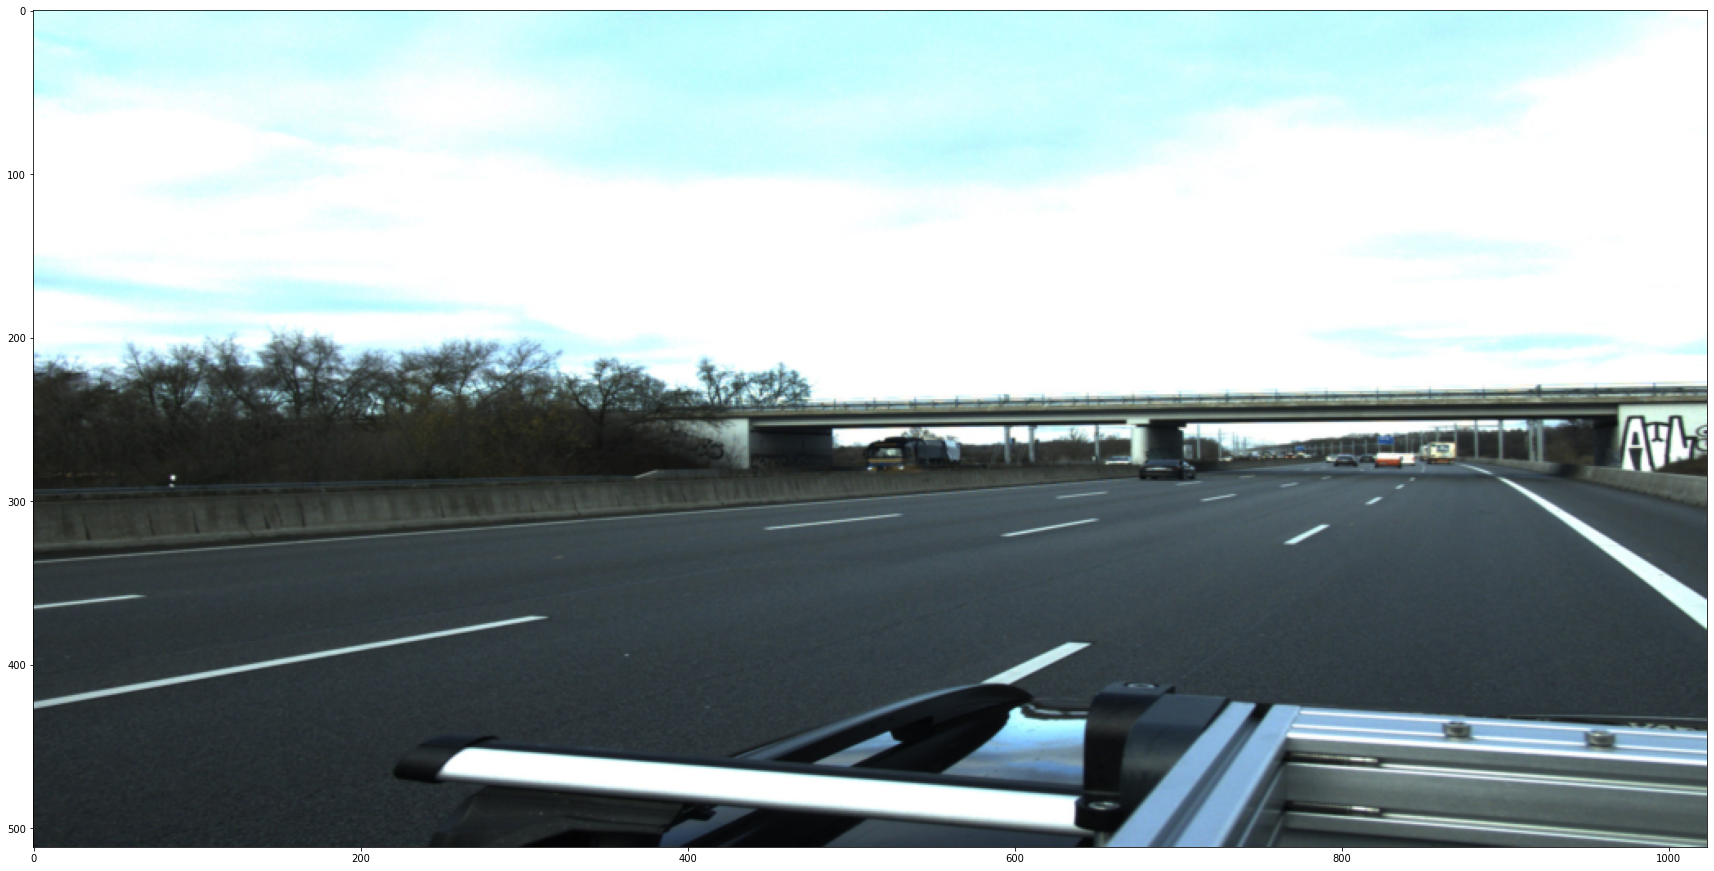

In [92]:
#plot image
import matplotlib.pyplot as plt
plt.imshow(data_set[0][0].numpy().transpose(1,2,0))
# plt.savefig("/content/drive/MyDrive/siemenschallenge5_2021/software/test.png")

In [93]:
full_data = data_set
#give percentage for val, test
val_set_perc = 0.5
test_set_perc = 0.15
val_size = int(val_set_perc * len(full_data))
test_size = int(test_set_perc * len(full_data))
train_size = len(full_data) - test_size - val_size
train_set, val_set, test_set = torch.utils.data.random_split(full_data, [train_size, val_size, test_size])

In [94]:
print("length of train set is", len(train_set))

length of train set is 4


In [95]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
htc_gpu = torch.cuda.device_count() if device.type=='cuda' else 0
kwargs = {'num_workers': 4*htc_gpu, 'pin_memory': True} if device == 'cuda' else {}

#=============define network parameters=================
num_epochs = 2
batch_size = 2
out_path = "/content/drive/MyDrive/siemenschallenge5_2021/software/outputs"#output path 
valid_after=1#valication every n epochs
lr=1e-4
use_saved=False#use previously saved model

In [96]:
#add model
import torch
import torch.nn.functional as F
from torch import nn
from torchvision import models

def make_decoder_block(in_channels, middle_channels, out_channels, if_convtrans=False, noupsam=False, upsc=2):
    """make decoder layer of unet
    Parameters
    ----------
    in_channels : int
        input channel count
    middle_channels :int
        middle channel count
    out_channels : int
        output channel count
    if_convtrans : bool, optional
        if transposed convolution to be used, by default False
    noupsam : bool, optional
        if output array not to be upsampled, by default False
    Returns
    -------
    tensor
        output from decoder layer
    """
    if noupsam:
        upsam = nn.ModuleList([nn.Conv2d(middle_channels, out_channels, 3, padding=1, bias=False),
            nn.InstanceNorm2d(out_channels)])
    elif if_convtrans:
        upsam = nn.ModuleList([nn.ConvTranspose2d(
                middle_channels, out_channels, kernel_size=4, stride=2, padding=1)])
    else:
        upsam = nn.ModuleList([nn.Conv2d(middle_channels, out_channels, 3, padding=1, bias=False),
            nn.InstanceNorm2d(out_channels),
            nn.Upsample(scale_factor=upsc, mode='bilinear', align_corners=False)])
    return nn.Sequential(
        nn.Conv2d(in_channels, middle_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        *upsam,
        nn.ReLU(inplace=True))
    # else:
    #     return nn.Sequential(
    #         nn.Conv2d(in_channels, middle_channels, 3, padding=1),
    #         nn.InstanceNorm2d(middle_channels),
    #         nn.ReLU(inplace=True),
    #         nn.Conv2d(middle_channels, out_channels, 3, padding=1),
    #         nn.InstanceNorm2d(out_channels),
    #         nn.Upsample(scale_factor=2, mode='bilinear'),
    #         nn.ReLU(inplace=True))
# In[12]:
class UNetVgg(nn.Module):
# adapted from https://github.com/skorch-dev/skorch/blob/master/examples/nuclei_image_segmentation/model.py
    def __init__(self, pretrained=False, out_classes=3, patch_train=False, if_convtrans=False):
        """unet with encoding layers from vgg
        Parameters
        ----------
        pretrained : bool, optional
            if pretrained, by default False
        out_classes : int, optional
            output channel count, by default 3
        patch_train : bool, optional
            if patches are input, by default False
        if_convtrans : bool, optional
            if transposed convolution to be used, by default False
        """
        super(UNetVgg, self).__init__()
        self.patch_train = patch_train
        encoder = models.vgg16_bn(pretrained=pretrained).features

        self.conv1 = encoder[:6]
        self.conv2 = encoder[6:13]
        self.conv3 = encoder[13:23]
        self.conv4 = encoder[23:33]
        self.conv5 = encoder[33:43]

        self.center = nn.Sequential(
            encoder[43],  # MaxPool
            make_decoder_block(512, 512, 256, if_convtrans=if_convtrans))

        self.dec5 = make_decoder_block(256 + 512, 512, 256, if_convtrans=if_convtrans)
        self.dec4 = make_decoder_block(256 + 512, 512, 256, if_convtrans=if_convtrans)
        self.dec3 = make_decoder_block(256 + 256, 256, 64, if_convtrans=if_convtrans)
        self.dec2 = make_decoder_block(64 + 128, 128, 32, if_convtrans=if_convtrans)
        self.dec1 = nn.Sequential(
            nn.Conv2d(32 + 64, 32, 3, padding=1), nn.ReLU(inplace=True))
        self.final = nn.Conv2d(32, out_classes, kernel_size=1)

    def forward(self, x):
            conv1 = self.conv1(x)
            conv2 = self.conv2(conv1)
            conv3 = self.conv3(conv2)
            conv4 = self.conv4(conv3)
            conv5 = self.conv5(conv4)

            center = self.center(conv5)

            dec5 = self.dec5(torch.cat([center, conv5], 1))
            dec4 = self.dec4(torch.cat([dec5, conv4], 1))
            dec3 = self.dec3(torch.cat([dec4, conv3], 1))
            dec2 = self.dec2(torch.cat([dec3, conv2], 1))
            dec1 = self.dec1(torch.cat([dec2, conv1], 1))

            return self.final(dec1)



In [97]:
#added model from https://github.com/fregu856/deeplabv3

import torch
import torch.nn as nn
import torch.nn.functional as F

class ASPP(nn.Module):
    def __init__(self, num_classes):
        super(ASPP, self).__init__()

        self.conv_1x1_1 = nn.Conv2d(512, 256, kernel_size=1)
        self.bn_conv_1x1_1 = nn.BatchNorm2d(256)

        self.conv_3x3_1 = nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=6, dilation=6)
        self.bn_conv_3x3_1 = nn.BatchNorm2d(256)

        self.conv_3x3_2 = nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=12, dilation=12)
        self.bn_conv_3x3_2 = nn.BatchNorm2d(256)

        self.conv_3x3_3 = nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=18, dilation=18)
        self.bn_conv_3x3_3 = nn.BatchNorm2d(256)

        self.avg_pool = nn.AdaptiveAvgPool2d(1)

        self.conv_1x1_2 = nn.Conv2d(512, 256, kernel_size=1)
        self.bn_conv_1x1_2 = nn.BatchNorm2d(256)

        self.conv_1x1_3 = nn.Conv2d(1280, 256, kernel_size=1) # (1280 = 5*256)
        self.bn_conv_1x1_3 = nn.BatchNorm2d(256)

        self.conv_1x1_4 = nn.Conv2d(256, num_classes, kernel_size=1)

    def forward(self, feature_map):
        # (feature_map has shape (batch_size, 512, h/16, w/16)) (assuming self.resnet is ResNet18_OS16 or ResNet34_OS16. If self.resnet instead is ResNet18_OS8 or ResNet34_OS8, it will be (batch_size, 512, h/8, w/8))

        feature_map_h = feature_map.size()[2] # (== h/16)
        feature_map_w = feature_map.size()[3] # (== w/16)

        out_1x1 = F.relu(self.bn_conv_1x1_1(self.conv_1x1_1(feature_map))) # (shape: (batch_size, 256, h/16, w/16))
        out_3x3_1 = F.relu(self.bn_conv_3x3_1(self.conv_3x3_1(feature_map))) # (shape: (batch_size, 256, h/16, w/16))
        out_3x3_2 = F.relu(self.bn_conv_3x3_2(self.conv_3x3_2(feature_map))) # (shape: (batch_size, 256, h/16, w/16))
        out_3x3_3 = F.relu(self.bn_conv_3x3_3(self.conv_3x3_3(feature_map))) # (shape: (batch_size, 256, h/16, w/16))

        out_img = self.avg_pool(feature_map) # (shape: (batch_size, 512, 1, 1))
        out_img = F.relu(self.bn_conv_1x1_2(self.conv_1x1_2(out_img))) # (shape: (batch_size, 256, 1, 1))
        out_img = F.upsample(out_img, size=(feature_map_h, feature_map_w), mode="bilinear") # (shape: (batch_size, 256, h/16, w/16))

        out = torch.cat([out_1x1, out_3x3_1, out_3x3_2, out_3x3_3, out_img], 1) # (shape: (batch_size, 1280, h/16, w/16))
        out = F.relu(self.bn_conv_1x1_3(self.conv_1x1_3(out))) # (shape: (batch_size, 256, h/16, w/16))
        out = self.conv_1x1_4(out) # (shape: (batch_size, num_classes, h/16, w/16))

        return out

class ASPP_Bottleneck(nn.Module):
    def __init__(self, num_classes):
        super(ASPP_Bottleneck, self).__init__()

        self.conv_1x1_1 = nn.Conv2d(4*512, 256, kernel_size=1)
        self.bn_conv_1x1_1 = nn.BatchNorm2d(256)

        self.conv_3x3_1 = nn.Conv2d(4*512, 256, kernel_size=3, stride=1, padding=6, dilation=6)
        self.bn_conv_3x3_1 = nn.BatchNorm2d(256)

        self.conv_3x3_2 = nn.Conv2d(4*512, 256, kernel_size=3, stride=1, padding=12, dilation=12)
        self.bn_conv_3x3_2 = nn.BatchNorm2d(256)

        self.conv_3x3_3 = nn.Conv2d(4*512, 256, kernel_size=3, stride=1, padding=18, dilation=18)
        self.bn_conv_3x3_3 = nn.BatchNorm2d(256)

        self.avg_pool = nn.AdaptiveAvgPool2d(1)

        self.conv_1x1_2 = nn.Conv2d(4*512, 256, kernel_size=1)
        self.bn_conv_1x1_2 = nn.BatchNorm2d(256)

        self.conv_1x1_3 = nn.Conv2d(1280, 256, kernel_size=1) # (1280 = 5*256)
        self.bn_conv_1x1_3 = nn.BatchNorm2d(256)

        self.conv_1x1_4 = nn.Conv2d(256, num_classes, kernel_size=1)

    def forward(self, feature_map):
        # (feature_map has shape (batch_size, 4*512, h/16, w/16))

        feature_map_h = feature_map.size()[2] # (== h/16)
        feature_map_w = feature_map.size()[3] # (== w/16)

        out_1x1 = F.relu(self.bn_conv_1x1_1(self.conv_1x1_1(feature_map))) # (shape: (batch_size, 256, h/16, w/16))
        out_3x3_1 = F.relu(self.bn_conv_3x3_1(self.conv_3x3_1(feature_map))) # (shape: (batch_size, 256, h/16, w/16))
        out_3x3_2 = F.relu(self.bn_conv_3x3_2(self.conv_3x3_2(feature_map))) # (shape: (batch_size, 256, h/16, w/16))
        out_3x3_3 = F.relu(self.bn_conv_3x3_3(self.conv_3x3_3(feature_map))) # (shape: (batch_size, 256, h/16, w/16))

        out_img = self.avg_pool(feature_map) # (shape: (batch_size, 512, 1, 1))
        out_img = F.relu(self.bn_conv_1x1_2(self.conv_1x1_2(out_img))) # (shape: (batch_size, 256, 1, 1))
        out_img = F.upsample(out_img, size=(feature_map_h, feature_map_w), mode="bilinear") # (shape: (batch_size, 256, h/16, w/16))

        out = torch.cat([out_1x1, out_3x3_1, out_3x3_2, out_3x3_3, out_img], 1) # (shape: (batch_size, 1280, h/16, w/16))
        out = F.relu(self.bn_conv_1x1_3(self.conv_1x1_3(out))) # (shape: (batch_size, 256, h/16, w/16))
        out = self.conv_1x1_4(out) # (shape: (batch_size, num_classes, h/16, w/16))

        return out

In [98]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

def make_layer(block, in_channels, channels, num_blocks, stride=1, dilation=1):
    strides = [stride] + [1]*(num_blocks - 1) # (stride == 2, num_blocks == 4 --> strides == [2, 1, 1, 1])

    blocks = []
    for stride in strides:
        blocks.append(block(in_channels=in_channels, channels=channels, stride=stride, dilation=dilation))
        in_channels = block.expansion*channels

    layer = nn.Sequential(*blocks) # (*blocks: call with unpacked list entires as arguments)

    return layer

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, channels, stride=1, dilation=1):
        super(BasicBlock, self).__init__()

        out_channels = self.expansion*channels

        self.conv1 = nn.Conv2d(in_channels, channels, kernel_size=3, stride=stride, padding=dilation, dilation=dilation, bias=False)
        self.bn1 = nn.BatchNorm2d(channels)

        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=dilation, dilation=dilation, bias=False)
        self.bn2 = nn.BatchNorm2d(channels)

        if (stride != 1) or (in_channels != out_channels):
            conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)
            bn = nn.BatchNorm2d(out_channels)
            self.downsample = nn.Sequential(conv, bn)
        else:
            self.downsample = nn.Sequential()

    def forward(self, x):
        # (x has shape: (batch_size, in_channels, h, w))

        out = F.relu(self.bn1(self.conv1(x))) # (shape: (batch_size, channels, h, w) if stride == 1, (batch_size, channels, h/2, w/2) if stride == 2)
        out = self.bn2(self.conv2(out)) # (shape: (batch_size, channels, h, w) if stride == 1, (batch_size, channels, h/2, w/2) if stride == 2)

        out = out + self.downsample(x) # (shape: (batch_size, channels, h, w) if stride == 1, (batch_size, channels, h/2, w/2) if stride == 2)

        out = F.relu(out) # (shape: (batch_size, channels, h, w) if stride == 1, (batch_size, channels, h/2, w/2) if stride == 2)

        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, channels, stride=1, dilation=1):
        super(Bottleneck, self).__init__()

        out_channels = self.expansion*channels

        self.conv1 = nn.Conv2d(in_channels, channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(channels)

        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, stride=stride, padding=dilation, dilation=dilation, bias=False)
        self.bn2 = nn.BatchNorm2d(channels)

        self.conv3 = nn.Conv2d(channels, out_channels, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)

        if (stride != 1) or (in_channels != out_channels):
            conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)
            bn = nn.BatchNorm2d(out_channels)
            self.downsample = nn.Sequential(conv, bn)
        else:
            self.downsample = nn.Sequential()

    def forward(self, x):
        # (x has shape: (batch_size, in_channels, h, w))

        out = F.relu(self.bn1(self.conv1(x))) # (shape: (batch_size, channels, h, w))
        out = F.relu(self.bn2(self.conv2(out))) # (shape: (batch_size, channels, h, w) if stride == 1, (batch_size, channels, h/2, w/2) if stride == 2)
        out = self.bn3(self.conv3(out)) # (shape: (batch_size, out_channels, h, w) if stride == 1, (batch_size, out_channels, h/2, w/2) if stride == 2)

        out = out + self.downsample(x) # (shape: (batch_size, out_channels, h, w) if stride == 1, (batch_size, out_channels, h/2, w/2) if stride == 2)

        out = F.relu(out) # (shape: (batch_size, out_channels, h, w) if stride == 1, (batch_size, out_channels, h/2, w/2) if stride == 2)

        return out

class ResNet_Bottleneck_OS16(nn.Module):
    def __init__(self, num_layers):
        super(ResNet_Bottleneck_OS16, self).__init__()

        if num_layers == 50:
            resnet = models.resnet50()
            # load pretrained model:
            # resnet.load_state_dict(torch.load("/root/deeplabv3/pretrained_models/resnet/resnet50-19c8e357.pth"))
            # remove fully connected layer, avg pool and layer5:
            self.resnet = nn.Sequential(*list(resnet.children())[:-3])

            print ("pretrained resnet, 50")
        elif num_layers == 101:
            resnet = models.resnet101()
            # load pretrained model:
            # resnet.load_state_dict(torch.load("/root/deeplabv3/pretrained_models/resnet/resnet101-5d3b4d8f.pth"))
            # remove fully connected layer, avg pool and layer5:
            self.resnet = nn.Sequential(*list(resnet.children())[:-3])

            print ("pretrained resnet, 101")
        elif num_layers == 152:
            resnet = models.resnet152()
            # load pretrained model:
            # resnet.load_state_dict(torch.load("/root/deeplabv3/pretrained_models/resnet/resnet152-b121ed2d.pth"))
            # remove fully connected layer, avg pool and layer5:
            self.resnet = nn.Sequential(*list(resnet.children())[:-3])

            print ("pretrained resnet, 152")
        else:
            raise Exception("num_layers must be in {50, 101, 152}!")

        self.layer5 = make_layer(Bottleneck, in_channels=4*256, channels=512, num_blocks=3, stride=1, dilation=2)

    def forward(self, x):
        # (x has shape (batch_size, 3, h, w))

        # pass x through (parts of) the pretrained ResNet:
        c4 = self.resnet(x) # (shape: (batch_size, 4*256, h/16, w/16)) (it's called c4 since 16 == 2^4)

        output = self.layer5(c4) # (shape: (batch_size, 4*512, h/16, w/16))

        return output

class ResNet_BasicBlock_OS16(nn.Module):
    def __init__(self, num_layers):
        super(ResNet_BasicBlock_OS16, self).__init__()

        if num_layers == 18:
            resnet = models.resnet18()
            # load pretrained model:
            resnet.load_state_dict(torch.load("/content/drive/MyDrive/siemenschallenge5_2021/software/model/resnet18-5c106cde.pth"))
            # remove fully connected layer, avg pool and layer5:
            self.resnet = nn.Sequential(*list(resnet.children())[:-3])

            num_blocks = 2
            print ("pretrained resnet, 18")
        elif num_layers == 34:
            resnet = models.resnet34()
            # load pretrained model:
            # resnet.load_state_dict(torch.load("/root/deeplabv3/pretrained_models/resnet/resnet34-333f7ec4.pth"))
            # remove fully connected layer, avg pool and layer5:
            self.resnet = nn.Sequential(*list(resnet.children())[:-3])

            num_blocks = 3
            print ("pretrained resnet, 34")
        else:
            raise Exception("num_layers must be in {18, 34}!")

        self.layer5 = make_layer(BasicBlock, in_channels=256, channels=512, num_blocks=num_blocks, stride=1, dilation=2)

    def forward(self, x):
        # (x has shape (batch_size, 3, h, w))

        # pass x through (parts of) the pretrained ResNet:
        c4 = self.resnet(x) # (shape: (batch_size, 256, h/16, w/16)) (it's called c4 since 16 == 2^4)

        output = self.layer5(c4) # (shape: (batch_size, 512, h/16, w/16))

        return output

class ResNet_BasicBlock_OS8(nn.Module):
    def __init__(self, num_layers):
        super(ResNet_BasicBlock_OS8, self).__init__()

        if num_layers == 18:
            resnet = models.resnet18()
            # load pretrained model:
            # resnet.load_state_dict(torch.load("/root/deeplabv3/pretrained_models/resnet/resnet18-5c106cde.pth"))
            # remove fully connected layer, avg pool, layer4 and layer5:
            self.resnet = nn.Sequential(*list(resnet.children())[:-4])

            num_blocks_layer_4 = 2
            num_blocks_layer_5 = 2
            print ("pretrained resnet, 18")
        elif num_layers == 34:
            resnet = models.resnet34()
            # load pretrained model:
            # resnet.load_state_dict(torch.load("/root/deeplabv3/pretrained_models/resnet/resnet34-333f7ec4.pth"))
            # remove fully connected layer, avg pool, layer4 and layer5:
            self.resnet = nn.Sequential(*list(resnet.children())[:-4])

            num_blocks_layer_4 = 6
            num_blocks_layer_5 = 3
            print ("pretrained resnet, 34")
        else:
            raise Exception("num_layers must be in {18, 34}!")

        self.layer4 = make_layer(BasicBlock, in_channels=128, channels=256, num_blocks=num_blocks_layer_4, stride=1, dilation=2)

        self.layer5 = make_layer(BasicBlock, in_channels=256, channels=512, num_blocks=num_blocks_layer_5, stride=1, dilation=4)

    def forward(self, x):
        # (x has shape (batch_size, 3, h, w))

        # pass x through (parts of) the pretrained ResNet:
        c3 = self.resnet(x) # (shape: (batch_size, 128, h/8, w/8)) (it's called c3 since 8 == 2^3)

        output = self.layer4(c3) # (shape: (batch_size, 256, h/8, w/8))
        output = self.layer5(output) # (shape: (batch_size, 512, h/8, w/8))

        return output

def ResNet18_OS16():
    return ResNet_BasicBlock_OS16(num_layers=18)

def ResNet34_OS16():
    return ResNet_BasicBlock_OS16(num_layers=34)

def ResNet50_OS16():
    return ResNet_Bottleneck_OS16(num_layers=50)

def ResNet101_OS16():
    return ResNet_Bottleneck_OS16(num_layers=101)

def ResNet152_OS16():
    return ResNet_Bottleneck_OS16(num_layers=152)

def ResNet18_OS8():
    return ResNet_BasicBlock_OS8(num_layers=18)

def ResNet34_OS8():
    return ResNet_BasicBlock_OS8(num_layers=34)

In [99]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import os

# from resnet import ResNet18_OS16, ResNet34_OS16, ResNet50_OS16, ResNet101_OS16, ResNet152_OS16, ResNet18_OS8, ResNet34_OS8
# from aspp import ASPP, ASPP_Bottleneck

class DeepLabV3(nn.Module):
    def __init__(self, model_id, project_dir):
        super(DeepLabV3, self).__init__()

        self.num_classes = 20

        self.model_id = model_id
        self.project_dir = project_dir
        self.create_model_dirs()

        self.resnet = ResNet18_OS8() # NOTE! specify the type of ResNet here
        self.aspp = ASPP(num_classes=self.num_classes) # NOTE! if you use ResNet50-152, set self.aspp = ASPP_Bottleneck(num_classes=self.num_classes) instead

    def forward(self, x):
        # (x has shape (batch_size, 3, h, w))

        h = x.size()[2]
        w = x.size()[3]

        feature_map = self.resnet(x) # (shape: (batch_size, 512, h/16, w/16)) (assuming self.resnet is ResNet18_OS16 or ResNet34_OS16. If self.resnet is ResNet18_OS8 or ResNet34_OS8, it will be (batch_size, 512, h/8, w/8). If self.resnet is ResNet50-152, it will be (batch_size, 4*512, h/16, w/16))

        output = self.aspp(feature_map) # (shape: (batch_size, num_classes, h/16, w/16))

        output = F.upsample(output, size=(h, w), mode="bilinear") # (shape: (batch_size, num_classes, h, w))

        return output

    def create_model_dirs(self):
        self.logs_dir = self.project_dir + "/training_logs"
        self.model_dir = self.logs_dir + "/model_%s" % self.model_id
        self.checkpoints_dir = self.model_dir + "/checkpoints"
        if not os.path.exists(self.logs_dir):
            os.makedirs(self.logs_dir)
        if not os.path.exists(self.model_dir):
            os.makedirs(self.model_dir)
            os.makedirs(self.checkpoints_dir)

In [100]:
net_model = DeepLabV3("resnet5002o18","/content/drive/MyDrive/siemenschallenge5_2021/software/outputs")

pretrained resnet, 18


In [101]:
#choose image number

im = data_set[5][0]
import torch
checkpoint = torch.load("/content/drive/MyDrive/siemenschallenge5_2021/software/model/model_13_2_2_2_epoch_580.pth",map_location=torch.device('cpu'))
net_model.load_state_dict(checkpoint)
net_model.eval()
bat1 = im.view(1,3,im.shape[-2],im.shape[-1])
out = net_model(bat1)
# sft = nn.Softmax2d()
# out = sft(out)
out = torch.argmax(out, dim=1)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


torch.Size([1, 512, 1024])


<Figure size 1200x800 with 0 Axes>

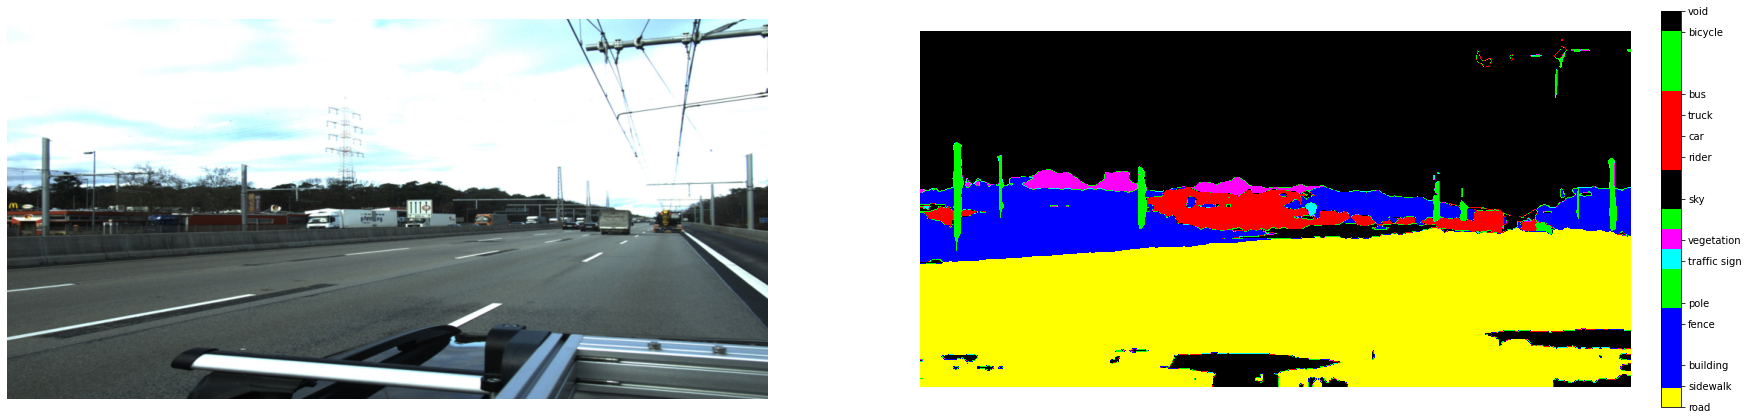

In [104]:
import matplotlib
torch.unique(out)
print(out.shape)

plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.rcParams['figure.figsize'] = [30, 25]
f, a = plt.subplots(1,2)
[axe.axis("off") for axe in a]

a[0].imshow(im.numpy().transpose(1,2,0))
colorsList = [(1, 1, 0), #1
              (0, 0, 1), 
              (0, 0, 1),#3
              (0, 0, 1),
              (0, 0, 1),#5
              (0, 1, 0),
              (0, 1, 0),
              (0, 1, 1),
              (1, 0, 1),
              (0, 1, 0),
              (0, 0, 0),#11
              (0, 0, 0),
              (1, 0, 0),#13
              (1, 0, 0),
              (1, 0, 0),
              (1, 0, 0),
              (0, 1, 0),#17
              (0, 1, 0),
              (0, 1, 0),
              (0, 0, 0)]#20]
              
CustomCmap = matplotlib.colors.ListedColormap(colorsList)
dis = a[1].imshow(out[0], cmap=CustomCmap)#'rainbow')
cbar = f.colorbar(dis, fraction=0.026, pad=0.04)

uni_ind=torch.unique(out)
k=['road','sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light', 'traffic sign', 'vegetation', 'terrain', 'sky', 'person',
                     'rider', 'car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle','void']
cbar_tick = [uni_ind[i].item() for i in range(len(uni_ind))]
cbar_lab = [k[uni_ind[i].item()] for i in range(len(uni_ind))]


cbar.set_ticks(cbar_tick)
cbar.set_ticklabels(cbar_lab)

# cbar.set_ticks(range(20))
# cbar.set_ticklabels(['road','sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light', 'traffic sign', 'vegetation', 'terrain', 'sky', 'person',
#                      'rider', 'car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle','void'])


['road',
 'sidewalk',
 'building',
 'wall',
 'fence',
 'traffic sign',
 'vegetation',
 'terrain',
 'sky',
 'car',
 'truck',
 'void']

In [ ]:
# add loss function
import torch
from torch import nn

def dice_loss_sq(pred, act, no_sft=False, is_all_chann=False):
    """computes dice loss (from dice coefficient squared)
    Parameters
    ----------
    pred : tensor
        predictions
    act : tensor
        target
    no_sft : bool, optional
        whether softmax to be applied on `pred`, by default False
    is_all_chann:bool, by default False
        whether to include all channels (or skip bg)
    Returns
    -------
    tensor
        dice loss
    """
    dice_coeff = dice_coefficient_sq(pred, act, no_sft=no_sft, is_all_chann=is_all_chann)  
    return 1-dice_coeff

def dice_coefficient_sq(probs, act, ignore_onlybg=False, no_sft=False, is_all_chann=False):
    """expects a batch of volumes as inputs, not single volume
    Parameters
    ----------
    probs : tensor
        predictions
    act : tensor
        actual segmentations
    ignore_onlybg: bool
        while computing average, ignore images having only bg
    no_sft:bool, by default False
        not to apply Softmax2d
    is_all_chann :  bool
        whether to include all channels while computing or to ignore first channel(bg)
    Returns
    -------
    tensor
        dice coefficient (squared version)
    """
    smooth=1
    if len(act.shape)!=4:
        act = act.view(act.shape[0],1,act.shape[2], act.shape[2])
        sgm_zer=(torch.zeros(act.shape[0],probs.shape[1],*act.shape[2:]))
        if act.is_cuda:
            sgm_zer = sgm_zer.to(act.get_device())
        act_hot = sgm_zer.scatter(1, act, 1)
    else:
        act_hot = act
    if not no_sft:
        sft_mx = nn.Softmax2d()
        probs = sft_mx(probs)
    num=probs*act_hot#b,c,h,w--p*g
    num = num.view(num.shape[0], num.shape[1], -1)
    num=torch.sum(num,dim=2)#b,    

    den1=probs*probs#--p^2
    den1=den1.view(den1.shape[0], den1.shape[1], -1)#b,c,h
    den1=torch.sum(den1,dim=2)
    

    den2=act_hot*act_hot#--g^2
    den2=den2.view(den2.shape[0], den2.shape[1], -1)#b,c,h
    den2=torch.sum(den2,dim=2)#b,c
    

    dice=(2*num+smooth)/(den1+den2+smooth)
    #we ignore bg dice val, and take the fg
    if is_all_chann or dice.shape[1]==1:
        dice_eso = dice
        num_fg_chann = torch.numel(dice[0,:])
    else:
        dice_eso=dice[:,1:]
        num_fg_chann = torch.numel(dice[0,1:])
    div_by = torch.numel(dice_eso)
    # consider only images having both foreground and bg labels
    imgfgbg_ind = torch.unique(torch.nonzero(act, as_tuple=True)[0])#num of items in batch with fg
    if len(imgfgbg_ind) and dice.shape[1]>1:
        cnt_fgbg = len(imgfgbg_ind)
        div_by = cnt_fgbg*num_fg_chann
    dice_coeff = torch.sum(dice_eso[imgfgbg_ind])/div_by
    return dice_coeff

In [ ]:
#===========================add loss/val func=======================================
loss_criterion = [dice_loss_sq]
val_acc_func = dice_loss_sq

In [ ]:
#training part
class AverageMeter(object):
    """
    https://github.com/pytorch/examples/blob/master/imagenet/main.py
    Computes and stores the average and current value
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def save_checkpoint(model, is_best, save_model_dir, del_pre_model=True, use_saved=False):
    """    https://github.com/pytorch/examples/blob/master/imagenet/main.py to save model
    Parameters
    ----------
    model : `torch.module`
        network model
    is_best : bool
        if best model among epochs
    save_model_dir : str
        directory path
    del_pre_model : bool, optional
        delete previously saved file, by default True
    """
    filename=os.path.join(save_model_dir, 'checkpoint_epoch'+str(model["epoch"])+'.pth.tar')
    if is_best:
        prev_model_state = [name for name in os.listdir(save_model_dir) if "epoch" in name]
        if del_pre_model and len(prev_model_state):
            os.unlink(os.path.join(save_model_dir, prev_model_state[0]))
        torch.save(model, filename)

def use_prev(model, save_model_dir):
    """allow pretrained parameters to load
    Parameters
    ----------
    model : `torch.module`
        model
    save_model_dir : str
        path of saved model
    Returns
    -------
    `torch.model`
        saved model
    """
    prev_model_state = [name for name in os.listdir(save_model_dir) if "epoch" in name]
    saved_epoch = int(prev_model_state[0].split('epoch')[1][0])
    prev_model = get_saved_model(model, save_model_dir, with_edge=False)
    if next(model.parameters()).is_cuda:
        prev_model = prev_model.cuda()
    else:
        prev_model = prev_model.cpu()        
    return prev_model, saved_epoch

In [ ]:
from torch.utils.data import DataLoader
from torch import nn
from tqdm import tqdm, notebook
from torch.autograd import Variable
from torch import optim
def train(train_loader, model, criterion, epoch, num_epochs, device, batch_size, optimizer=None, lr=1e-4, scheduler=None):
    """train model
    Parameters
    ----------
    train_loader : `torch.utils.data.DataLoader`
        data loader for train dataset
    model : `torch.module`
        model
    criterion : list
        list of loss functions
    epoch : int
        epoch number
    num_epochs : int
        number of epochs
    device : `torch.device`
        cpu or cuda
    batch_size : int
        batch size
    optimizer : `torch::optim::Optimizer`, optional
        optimizer, by default None
    lr : float, optional
        learning rate, by default 1e-4
    Returns
    -------
    float
        average loss
    """
    model.train()
    losses = AverageMeter()
    if optimizer is None:
        optimizer = optim.Adam(model.parameters(),lr=lr)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
    # set a progress bar
    pbar = tqdm(enumerate(train_loader), total=int(len(train_loader.dataset)/batch_size))
    # pbar = tqdm(iter(train_loader), total=len(train_loader.dataset))
    for i, (images, segm_act) in pbar:
        # Convert torch tensor to Variable
        images = Variable(images.to(device))#.cuda())
        segm_act = Variable(segm_act.to(device))#cuda())
        print("segm image shape", segm_act.shape)
        optimizer.zero_grad()
        # if isinstance(model, UNetVggTwo):
        outputs = model(images)

        # measure loss
        # loss = criterion(outputs, segm_act)
        aggr_loss = 0
        for loss_ind, loss in enumerate(criterion):
            loss_each = loss(outputs, segm_act)
            aggr_loss+=loss_each
        losses.update(aggr_loss.item(), images.size(0))

        # compute gradient and do SGD step
        aggr_loss.backward()
        optimizer.step()
        pbar.set_description('[TRAIN] - EPOCH %d/ %d - BATCH LOSS: %.4f/ %.4f(epoch avg) '
                             % (epoch + 1, num_epochs, losses.val, losses.avg))

    # return avg loss over the epoch
    return losses.avg, optimizer, scheduler

def evaluate(val_loader, model, criterion, val_acc_func, epoch, num_epochs, device, scheduler=None):
    """validate model
    Parameters
    ----------
    val_loader : `torch.utils.data.DataLoader`
        data loader for validation dataset
    model : `torch.module`
        model
    criterion : list
        list of loss functions
    epoch : int
        epoch number
    num_epochs : int
        number of epochs
    val_acc_func : list
        list of accuracy functions
    device : `torch.device`
        cpu or cuda
    Returns
    -------
    list
        average loss and/or accuracy
    """
    model.eval()
    losses = AverageMeter()
    val_accs = AverageMeter()

    # set a progress bar
    pbar = tqdm(enumerate(val_loader))#, total=len(val_loader))
    #pbar = tqdm(iter(val_loader), total=len(val_loader.dataset))
    for i, (images, segm_act) in pbar:
        # Convert torch tensor to Variable
        images = Variable(images.to(device))
        segm_act = Variable(segm_act.to(device))

        with torch.no_grad():
            # compute output
            outputs = model(images)

            # measure loss
            aggr_loss = 0
            for loss_ind, loss in enumerate(criterion):
                if isinstance(loss, nn.MSELoss):#for finding middle slices 
                    segm_actf = segm_act.type(torch.float)
                    loss_each = loss(outputs, segm_actf)
                else:
                    loss_each = loss(outputs, segm_act)
                aggr_loss+=loss_each
            losses.update(aggr_loss.item(), images.size(0))#aggr_loss.item()
            scheduler.step(aggr_loss)
            valid_val = val_acc_func(outputs, segm_act)
            val_accs.update(valid_val) #function already averages based on batch count
            loss_name = "VAL CRITERIA"
            pbar.set_description('[VALID] - EPOCH %d/ %d - BATCH LOSS: %.4f/ %.4f(epoch avg) - BATCH %s : %.4f/%.4f(epoch avg) '
                             % (epoch + 1, num_epochs, losses.val, losses.avg,loss_name, val_accs.val, val_accs.avg))
       
    # return avg loss over the epoch
    # if val_acc_func==dice_coefficient:
    #     print(f"hausdorff distance is {hdorff.avg.round(2)}")
    return losses.avg, val_accs.avg, scheduler




def plt_loss(data, max_epo, title, save_file_path, valid_after):
    """plot graphs
    Parameters
    ----------
    data : list
        loss and accuracy values in epochs
    max_epo : int
        number of epochs
    title : str
        title
    save_file_path : str
        save file path
    valid_after : int
        validation check every
    """
    fig_plt, ax_plt = plt.subplots(1, 3)
    fig_plt.set_size_inches(19, 7)
    for ind, ax in enumerate(ax_plt):
        xmax=len(data[ind])
        ax.plot(range(xmax), data[ind], 'dodgerblue')#, label='training')
        # plt.plot(range(max_epo), validation_history['loss'], 'orange', label='validation')
        ax.axis(xmin=0,xmax=xmax)
        ax.set_xlabel(f'Epochs/{valid_after}' if ind!=0 else "Epochs")
        # plt.ylabel('Loss')
        ax.set_title(title[ind])
    plt.savefig(save_file_path, bbox_inches="tight")
    plt.close("all")
    # plt.legend();

def valid(model,x_valid,y_valid,criterion):
    """validation
    Parameters
    ----------
    model : `torch.module`
        model
    x_valid : `torch.tensor'
        image dataset
    y_valid : `torch.tensor`
        target dataset
    criterion : `torch.nn`
        loss function
    Returns
    -------
    float
        loss
    """
    with torch.no_grad():
        model.eval()
        y_pred = model(x_valid)
        loss = criterion(y_pred, y_valid)
        print('test-loss',t, loss.item(),end=' ')
        return loss.item()

def naive_train(train_set, valid_set, model, criterion, val_acc_func, num_epochs, batch_size, device, out_path, kwargs, experiment_name="", 
valid_after=4, lr=1e-4, use_saved=False, optimizer=None, scheduler=None):
    """wrapper for train, valid 
    Parameters
    ----------
    train_set : `torch.utils.data.dataset.Dataset`
        training set
    valid_set : `torch.utils.data.dataset.Dataset`
        validation set
    model : `torch.module`
        model
    criterion : list
        list of loss functions
    val_acc_func : `list`
        list of accuracy functions
    num_epochs : int
        number of epochs
    batch_size : int
        batch size
    device : `torch.device`
        cpu or cuda
    out_path : str
        path of output dir
    kwargs : list
            num of workers, wheter to pin_memory
    experiment_name : str, optional
        name of expt, by default ""
    valid_after : int, optional
        validation check every, by default 4
    lr : float, optional
        learning rate, by default 1e-4
    use_saved : bool, by default False
        whether to pretrain
    """
    best_loss = 10000
    metric_dict = {"train_loss":[], "val_loss":[], "val_acc":[]}
    train_loader = DataLoader(train_set, batch_size=batch_size, **kwargs)
    val_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, **kwargs)
    prev_epo = 0
    if use_saved:
        model, prev_epo = use_prev(model, out_path)
        num_epochs = num_epochs - prev_epo
    for epoch in range(0, num_epochs):
        # train for one epoch
        curr_loss, optimizer, scheduler = train(train_loader, model, criterion, epoch, num_epochs, device, batch_size, lr=lr, optimizer=optimizer, scheduler=scheduler)
        metric_dict["train_loss"].append(curr_loss)

        if not epoch%valid_after:
            val_loss, val_acc, scheduler = evaluate(val_loader, model, criterion, val_acc_func, epoch, num_epochs, device, scheduler=scheduler)
            metric_dict["val_loss"].append(val_loss)
            metric_dict["val_acc"].append(val_acc)

            # store best loss and save a model checkpoint
            is_best = val_loss < best_loss
            best_loss = min(val_loss, best_loss)
            save_checkpoint({
                'epoch': epoch + 1 + prev_epo,
                'arch': experiment_name,
                'state_dict': model.state_dict(),
                # 'best_prec1': best_loss,
                # 'optimizer': optimizer.state_dict(),
            }, is_best, out_path)

    # logger.close()
    val_times = len(metric_dict["val_acc"])
    graph_path = os.path.join(out_path, "graph")# for graph_type in metric_dict.keys()]
    # list(map(plt_loss, metric_dict.values(),[num_epochs, val_times, val_times], metric_dict.keys(), graph_paths))
    plt_loss(list(metric_dict.values()),num_epochs, list(metric_dict.keys()), graph_path, valid_after)

In [ ]:
naive_train(train_set, val_set, net_model, loss_criterion, val_acc_func, num_epochs, batch_size, device, out_path, 
        kwargs, valid_after=valid_after, lr=lr, use_saved=use_saved)








  0%|          | 0/1 [00:00<?, ?it/s]

segm image shape torch.Size([2, 256, 256])









[TRAIN] - EPOCH 1/ 2 - BATCH LOSS: 1.0000/ 1.0000(epoch avg) :   0%|          | 0/1 [00:09<?, ?it/s]






[TRAIN] - EPOCH 1/ 2 - BATCH LOSS: 1.0000/ 1.0000(epoch avg) : 100%|██████████| 1/1 [00:09<00:00,  9.63s/it]







0it [00:00, ?it/s]






[VALID] - EPOCH 1/ 2 - BATCH LOSS: 1.0000/ 1.0000(epoch avg) - BATCH VAL CRITERIA : 1.0000/1.0000(epoch avg) : : 0it [00:03, ?it/s]






[VALID] - EPOCH 1/ 2 - BATCH LOSS: 1.0000/ 1.0000(epoch avg) - BATCH VAL CRITERIA : 1.0000/1.0000(epoch avg) : : 1it [00:03,  3.05s/it]







  0%|          | 0/1 [00:00<?, ?it/s]

segm image shape torch.Size([2, 256, 256])









[TRAIN] - EPOCH 2/ 2 - BATCH LOSS: 1.0000/ 1.0000(epoch avg) :   0%|          | 0/1 [00:09<?, ?it/s]






[TRAIN] - EPOCH 2/ 2 - BATCH LOSS: 1.0000/ 1.0000(epoch avg) : 100%|██████████| 1/1 [00:09<00:00,  9.77s/it]







0it [00:00, ?it/s]






[VALID] - EPOCH 2/ 2 - BATCH LOSS: 1.0000/ 1.0000(epoch avg) - BATCH VAL CRITERIA : 1.0000/1.0000(epoch avg) : : 0it [00:03, ?it/s]






[VALID] - EPOCH 2/ 2 - BATCH LOSS: 1.0000/ 1.0000(epoch avg) - BATCH VAL CRITERIA : 1.0000/1.0000(epoch avg) : : 1it [00:03,  3.58s/it]


0